In [11]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    ToolMessage,
)

In [12]:
load_dotenv()
model=ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage] , add_messages]

In [14]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def sub(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b

@tool
def mul(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a*b

@tool
def div(a: int, b:int) -> int:
    """This tool divides two numbers"""
    return a/b

In [15]:
my_tools = [add, sub, mul, div]
model=model.bind_tools(my_tools)

def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are a helpful assistant please answer the question to the best of your ability")
    messages = [system_prompt] + state['messages']
    response = model.invoke(messages)
    return {'messages': state['messages'] + [response]}

def should_continue(state: AgentState) -> AgentState:
    messages = state['messages']
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
    
    return "continue"

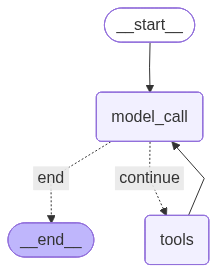

In [16]:
graph = StateGraph(AgentState)
graph.add_node('model_call', model_call)

tool_node = ToolNode(tools=my_tools) 

graph.add_node('tools', tool_node)

graph.add_edge(START, 'model_call')
graph.add_conditional_edges('model_call', should_continue, {'continue': 'tools', 'end': END})

graph.add_edge('tools', 'model_call')
graph.add_edge('model_call', END)

bot = graph.compile()

bot



In [17]:
def print_stream(stream):
    step = 0
    for s in stream:
        step += 1
        node_name, node_value = next(iter(s.items()))

        print(f"\n{'='*20} STEP {step} | NODE: {node_name} {'='*20}")

        messages = node_value.get("messages", [])
        if not messages:
            print("No messages")
            continue

        msg = messages[-1]

        # -------- Human --------
        if isinstance(msg, HumanMessage):
            print("👤 HumanMessage")
            print(msg.content)

        # -------- Tool --------
        elif isinstance(msg, ToolMessage):
            print("🛠️ ToolMessage")
            print(f"Tool name : {msg.name}")
            print(f"Result    : {msg.content}")

        # -------- AI --------
        elif isinstance(msg, AIMessage):
            print("🤖 AIMessage")

            # Tool call
            if msg.tool_calls:
                for tc in msg.tool_calls:
                    print("➡️ Tool Call")
                    print(f"  Tool : {tc['name']}")
                    print(f"  Args : {tc['args']}")
            else:
                print("➡️ Final Answer")
                print(msg.content)

        else:
            print("❓ Unknown message type")
            print(msg)



input={"messages": [("user", "add 40 and 12 and then subtract 10. also tell me a joke at the end")]}

print_stream(bot.stream(input))


==================== STEP 1 | NODE: model_call ====================
🤖 AIMessage
➡️ Tool Call
  Tool : add
  Args : {'a': 40, 'b': 12}

==================== STEP 2 | NODE: tools ====================
🛠️ ToolMessage
Tool name : add
Result    : 52

==================== STEP 3 | NODE: model_call ====================
🤖 AIMessage
➡️ Tool Call
  Tool : sub
  Args : {'a': 52, 'b': 10}

==================== STEP 4 | NODE: tools ====================
🛠️ ToolMessage
Tool name : sub
Result    : 42

==================== STEP 5 | NODE: model_call ====================
🤖 AIMessage
➡️ Final Answer
[{'type': 'text', 'text': "The answer is 42.\n\nWhy don't scientists trust atoms?\nBecause they make up everything!", 'extras': {'signature': 'CnYBcsjafBirDikScylEurB2hSCNZkYowTXoGmKBuMFHvmgXAkCytAguQmPH4ydbs9V/WrWsT62xRczTXYNXBml+3id8u/sc8nW7UKbiN3CdepE52KTlPYo2vl59iSN0Bzh6kJL7LHOFIwMWlh5CCFUqkmlDxsKa'}}]
